# CNN+LSTM(FINAL)





Epoch 1/50


29/29 [==============================] - 6s 84ms/step - loss: 2.3947 - accuracy: 0.2736 - val_loss: 4.5413 - val_accuracy: 0.0736
Epoch 2/50
29/29 [==============================] - 2s 69ms/step - loss: 0.8740 - accuracy: 0.7264 - val_loss: 4.5323 - val_accuracy: 0.0736
Epoch 3/50
29/29 [==============================] - 2s 68ms/step - loss: 0.3924 - accuracy: 0.8773 - val_loss: 3.3665 - val_accuracy: 0.2251
Epoch 4/50
29/29 [==============================] - 2s 66ms/step - loss: 0.1713 - accuracy: 0.9555 - val_loss: 1.4942 - val_accuracy: 0.5714
Epoch 5/50
29/29 [==============================] - 2s 65ms/step - loss: 0.1515 - accuracy: 0.9533 - val_loss: 1.1966 - val_accuracy: 0.6494
Epoch 6/50
29/29 [==============================] - 2s 74ms/step - loss: 0.0933 - accuracy: 0.9739 - val_loss: 0.4706 - val_accuracy: 0.8398
Epoch 7/50
29/29 [==============================] - 2s 81ms/step - loss: 0.0460 - accuracy: 0.9902 - val_loss: 0.4201 - val_accuracy: 0.8701
Epoch 8

29/29 [==============================] - 2s 68ms/step - loss: 7.2967e-05 - accuracy: 1.0000 - val_loss: 0.1665 - val_accuracy: 0.9610
Epoch 49/50
29/29 [==============================] - 2s 68ms/step - loss: 9.6280e-05 - accuracy: 1.0000 - val_loss: 0.1658 - val_accuracy: 0.9610
Epoch 50/50
29/29 [==============================] - 2s 66ms/step - loss: 9.1210e-05 - accuracy: 1.0000 - val_loss: 0.1592 - val_accuracy: 0.9610
Feature Fusion Model Accuracy: 0.9652777910232544
9/9 [==============================] - 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00        13
           3       0.83      0.83      0.83         6
           4       0.92      1.00      0.96        12
           5       1.00      0.93      0.96        14
           6       1.00      1.00      1.00        12
           7       0.93      1.00      0.97        14
           8    

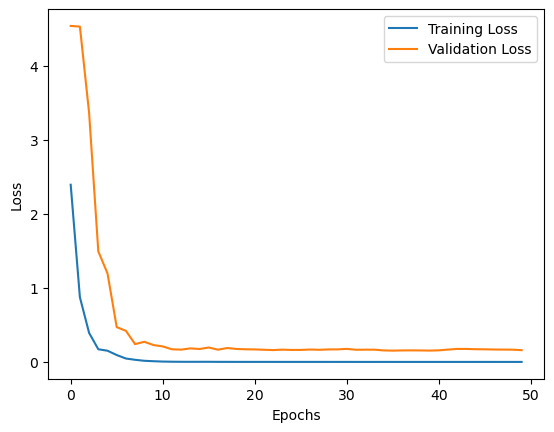

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LSTM, Dropout, Permute, Reshape, Input, concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.metrics import classification_report

# Set random seeds for reproducibility
import random
import tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Function to extract features from an audio file
def extract_features(file_path, max_length=216, n_mfcc=13):
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=n_mfcc)

    # Pad or truncate the feature matrix to ensure a common length
    if mfccs.shape[1] < max_length:
        features = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])))
    else:
        features = mfccs[:, :max_length]

    # Add an extra dimension for the CNN input
    features = np.expand_dims(features, axis=-1)

    return features

# Directory containing audio files for speaker identification
audio_directory = 'D:\\College\\sem5\\Mat_5\\audio_speech_actors_01-24\\'

# Collect file paths and corresponding labels
file_paths = []
labels = []

for actor_folder in os.listdir(audio_directory):
    actor_path = os.path.join(audio_directory, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                file_paths.append(os.path.join(actor_path, filename))
                labels.append(int(actor_folder.split('_')[-1]))

# Convert labels to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(file_paths, categorical_labels, test_size=0.2, random_state=42)

# Extract features for training and testing
max_length = 216  # Set the desired maximum length of feature sequences
features_train = np.array([extract_features(file, max_length, n_mfcc=13) for file in X_train])
features_test = np.array([extract_features(file, max_length, n_mfcc=13) for file in X_test])

# Feature Fusion Model
input_shape = (13, max_length, 1)
input_layer = Input(shape=input_shape)

# CNN branch
cnn_branch = Conv2D(64, kernel_size=(3, 3), activation='relu')(input_layer)
cnn_branch = BatchNormalization()(cnn_branch)
cnn_branch = MaxPooling2D(pool_size=(2, 2))(cnn_branch)
cnn_branch = Conv2D(128, kernel_size=(3, 3), activation='relu')(cnn_branch)
cnn_branch = BatchNormalization()(cnn_branch)
cnn_branch = MaxPooling2D(pool_size=(2, 2))(cnn_branch)
cnn_branch = Permute((2, 1, 3))(cnn_branch)
cnn_branch = Reshape((cnn_branch.shape[1], cnn_branch.shape[2] * cnn_branch.shape[3]))(cnn_branch)
cnn_branch = LSTM(64, return_sequences=True)(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# MFCC + Chroma branch
mfcc_chroma_branch = GlobalAveragePooling2D()(input_layer)

# Concatenate the outputs of both branches
merged = concatenate([cnn_branch, mfcc_chroma_branch])

# Dense layers for the merged features
merged = Dense(512, activation='relu')(merged)
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(merged)

# Create the Feature Fusion model
feature_fusion_model = Model(inputs=input_layer, outputs=output_layer)
feature_fusion_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Feature Fusion model with more epochs and plot training curves
history = feature_fusion_model.fit(features_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the Feature Fusion model on the test set
_, accuracy_feature_fusion = feature_fusion_model.evaluate(features_test, y_test, verbose=0)
print(f"Feature Fusion Model Accuracy: {accuracy_feature_fusion}")

# Predict the labels for the test set
y_pred = feature_fusion_model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Convert class indices back to original labels for classification report
class_names = [str(label) for label in label_encoder.classes_]

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


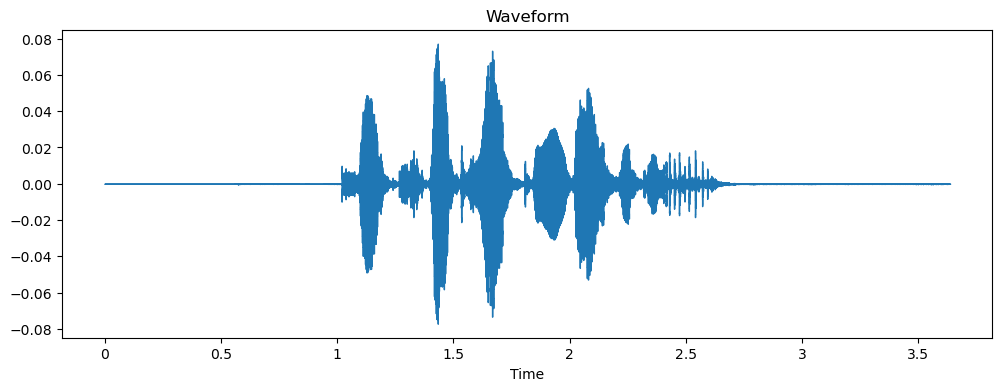

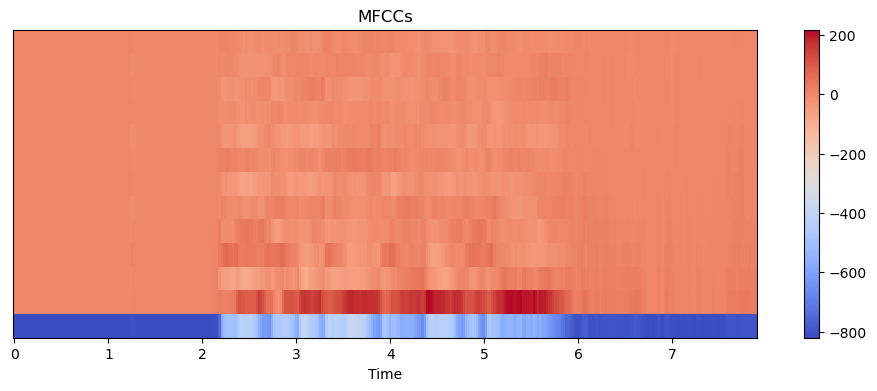

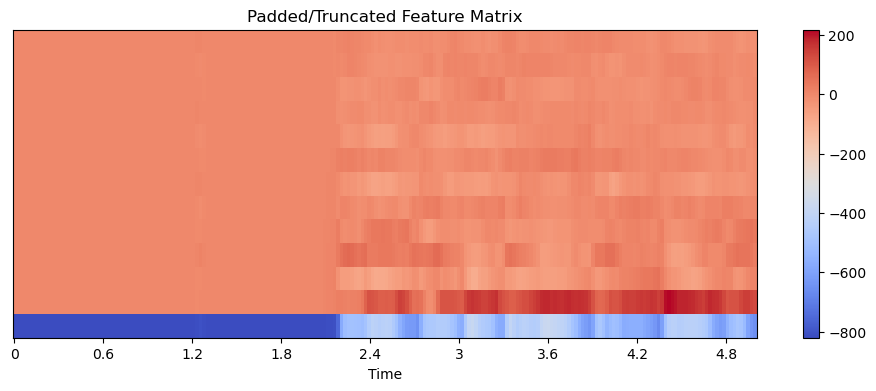

1/1 [==============================] - 1s 550ms/step


Predicted Speaker on RAVDESS file: 2


In [2]:
# Function to predict the speaker using the trained CNN model
from IPython.display import Audio
def predict_speaker(model, file_path, max_length=216):
    # Extract features from the audio file
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)

    # Pad or truncate the feature matrix to ensure a common length
    if mfccs.shape[1] < max_length:
        features = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])))
    else:
        features = mfccs[:, :max_length]

    # Add an extra dimension for the CNN input
    features = np.expand_dims(features, axis=-1)

    # Plot the waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=sample_rate)
    plt.title('Waveform')
    plt.show()

    # Plot the MFCCs
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.show()

    # Plot the padded/truncated feature matrix
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(features[:, :, 0], x_axis='time')
    plt.colorbar()
    plt.title('Padded/Truncated Feature Matrix')
    plt.show()

    # Make a prediction using the trained model
    predictions = model.predict(np.expand_dims(features, axis=0))
    
    # Get the predicted label
    predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])[0]
    
    # Play the audio file
    display(Audio(data=waveform, rate=sample_rate))
    
    return predicted_label

test_file_path_ravdess = 'D:\\College\\sem5\\Mat_5\\audio_speech_actors_01-24\\Actor_02\\03-01-01-01-01-01-02.wav'

predicted_speaker_ravdess = predict_speaker(feature_fusion_model, test_file_path_ravdess)

print(f"Predicted Speaker on RAVDESS file: {predicted_speaker_ravdess}")

# CNN

In [5]:
import os
import librosa
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import random
import tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def extract_features(file_path, max_length=216):
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)

    # Pad or truncate the feature matrix to ensure a common length
    if mfccs.shape[1] < max_length:
        features = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])))
    else:
        features = mfccs[:, :max_length]

    # Add an extra dimension for the CNN input
    features = np.expand_dims(features, axis=-1)

    return features

# Directory containing audio files for speaker identification
audio_directory = 'D:\\College\\sem5\\Mat_5\\audio_speech_actors_01-24\\'

# Collect file paths and corresponding labels
file_paths = []
labels = []

for actor_folder in os.listdir(audio_directory):
    actor_path = os.path.join(audio_directory, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                file_paths.append(os.path.join(actor_path, filename))
                labels.append(int(actor_folder.split('_')[-1]))

# Convert labels to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(file_paths, categorical_labels, test_size=0.2, random_state=42)

# Extract features for training and testing
max_length = 216  # Set the desired maximum length of feature sequences
features_train = np.array([extract_features(file, max_length) for file in X_train])
features_test = np.array([extract_features(file, max_length) for file in X_test])

# Build the CNN model
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(13, max_length, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model with a lower learning rate
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model with more epochs
model.fit(features_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = model.predict(features_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
class_names = [str(label) for label in label_encoder.classes_]
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


Epoch 1/50
29/29 [==============================] - 7s 120ms/step - loss: 5.9940 - accuracy: 0.1314 - val_loss: 6.4348 - val_accuracy: 0.0346
Epoch 2/50
29/29 [==============================] - 3s 92ms/step - loss: 1.8418 - accuracy: 0.4224 - val_loss: 5.5234 - val_accuracy: 0.1212
Epoch 3/50
29/29 [==============================] - 3s 95ms/step - loss: 0.9381 - accuracy: 0.7036 - val_loss: 3.4288 - val_accuracy: 0.1991
Epoch 4/50
29/29 [==============================] - 3s 99ms/step - loss: 0.3867 - accuracy: 0.8936 - val_loss: 1.6894 - val_accuracy: 0.4329
Epoch 5/50
29/29 [==============================] - 3s 99ms/step - loss: 0.1566 - accuracy: 0.9750 - val_loss: 1.1476 - val_accuracy: 0.6061
Epoch 6/50
29/29 [==============================] - 3s 98ms/step - loss: 0.0788 - accuracy: 0.9924 - val_loss: 0.9166 - val_accuracy: 0.7186
Epoch 7/50
29/29 [==============================] - 3s 97ms/step - loss: 0.0339 - accuracy: 0.9989 - val_loss: 0.7028 - val_accuracy: 0.7835
Epoch 8/50
2

In [7]:
_, accuracy_cnn = model.evaluate(features_test, y_test, verbose=0)
print(f"CNN Model Accuracy: {accuracy_cnn}")

CNN Model Accuracy: 0.8819444179534912


# GMM

In [14]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, accuracy_score

# Set random seeds for reproducibility
import random
import tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Function to extract features from an audio file
def extract_features(file_path, max_length=216):
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)

    # Pad or truncate the feature matrix to ensure a common length
    if mfccs.shape[1] < max_length:
        features = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])))
    else:
        features = mfccs[:, :max_length]

    # Normalize the features
    features = librosa.util.normalize(features)

    return features.flatten()

# Directory containing audio files for speaker identification
audio_directory = 'D:\\College\\sem5\\Mat_5\\audio_speech_actors_01-24\\'

# Collect file paths and corresponding labels
file_paths = []
labels = []

for actor_folder in os.listdir(audio_directory):
    actor_path = os.path.join(audio_directory, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                file_paths.append(os.path.join(actor_path, filename))
                labels.append(int(actor_folder.split('_')[-1]))

# Convert labels to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(file_paths, categorical_labels, test_size=0.2, random_state=42)

# Extract features for training and testing
max_length = 216  # Set the desired maximum length of feature sequences
features_train = np.array([extract_features(file, max_length) for file in X_train])
features_test = np.array([extract_features(file, max_length) for file in X_test])

# Reshape the features for StandardScaler
reshaped_train_features = features_train.reshape((features_train.shape[0], -1))
reshaped_test_features = features_test.reshape((features_test.shape[0], -1))

# Feature scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(reshaped_train_features)
features_test_scaled = scaler.transform(reshaped_test_features)

# Build and train separate Gaussian Mixture Models for each speaker
speakers = set(encoded_labels)
gmm_models = {}

for speaker in speakers:
    speaker_features = features_train_scaled[y_train.argmax(axis=1) == speaker]
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)  # Adjust the number of components
    gmm.fit(speaker_features)
    gmm_models[speaker] = gmm

# Predict labels for the test set
y_pred = []

for test_feature in features_test_scaled:
    likelihoods = [gmm.score_samples(test_feature.reshape(1, -1))[0] for gmm in gmm_models.values()]
    predicted_speaker = np.argmax(likelihoods)
    y_pred.append(predicted_speaker)

# Evaluate the model on the test set
accuracy_gmm = accuracy_score(y_test.argmax(axis=1), y_pred)  # Adjust for one-hot encoding
print(f"GMM Model Accuracy: {accuracy_gmm}")

# Print classification report
class_names = [str(label) for label in label_encoder.classes_]
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=class_names))


C:\Users\surya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\surya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\surya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\surya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

GMM Model Accuracy: 0.8055555555555556
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.82      0.69        11
           2       0.81      1.00      0.90        13
           3       0.46      1.00      0.63         6
           4       1.00      1.00      1.00        12
           5       0.69      0.64      0.67        14
           6       0.83      0.83      0.83        12
           7       1.00      0.71      0.83        14
           8       1.00      0.89      0.94         9
           9       0.64      0.90      0.75        10
          10       0.91      0.62      0.74        16
          11       0.94      1.00      0.97        16
          12       1.00      1.00      1.00        10
          13       1.00      0.85      0.92        13
          14       0.85      0.92      0.88        12
          15       0.90      0.75      0.82        12
          16       1.00      0.60      0.75        15
          17       

# svm

In [1]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


# Function to extract features from an audio file
def extract_features(file_path, max_length=216):
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)

    # Pad or truncate the feature matrix to ensure a common length
    if mfccs.shape[1] < max_length:
        features = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])))
    else:
        features = mfccs[:, :max_length]

    return features.flatten()  # Flatten the features

# Directory containing audio files for speaker identification
audio_directory = 'D:\\College\\sem5\\Mat_5\\audio_speech_actors_01-24\\'

# Collect file paths and corresponding labels
file_paths = []
labels = []

for actor_folder in os.listdir(audio_directory):
    actor_path = os.path.join(audio_directory, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                file_paths.append(os.path.join(actor_path, filename))
                labels.append(int(actor_folder.split('_')[-1]))

# Convert labels to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets with a fixed random seed
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(file_paths, encoded_labels, test_size=0.2, random_state=random_seed)

# Extract features for training and testing
max_length = 216  # Set the desired maximum length of feature sequences
features_train = np.array([extract_features(file, max_length) for file in X_train])
features_test = np.array([extract_features(file, max_length) for file in X_test])

# Build and train SVM model with a fixed random seed
svm_model = make_pipeline(StandardScaler(), SVC(C=1.0, kernel='rbf', gamma='auto', random_state=random_seed))
svm_model.fit(features_train, y_train)

# Evaluate SVM model
y_pred_svm = svm_model.predict(features_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1score_svm = f1_score(y_test, y_pred_svm, average='weighted')

print(f"SVM Model Accuracy: {accuracy_svm}")
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))
print(f"\nPrecision (SVM): {precision_svm}")
print(f"Recall (SVM): {recall_svm}")
print(f"F1 Score (SVM): {f1score_svm}")

SVM Model Accuracy: 0.8680555555555556

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.79      0.85      0.81        13
           2       0.46      1.00      0.63         6
           3       0.80      1.00      0.89        12
           4       0.77      0.71      0.74        14
           5       0.83      0.83      0.83        12
           6       1.00      0.86      0.92        14
           7       0.90      1.00      0.95         9
           8       0.75      0.90      0.82        10
           9       0.88      0.88      0.88        16
          10       0.89      1.00      0.94        16
          11       0.90      0.90      0.90        10
          12       1.00      0.77      0.87        13
          13       1.00      1.00      1.00        12
          14       1.00      0.92      0.96        12
          15       0.92      0.73      0.81        15
          1